In [0]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.2.0-rc3
Found GPU at: /device:GPU:0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
#4/zAGkipCyWSnoEY7AsX4slThoFcLay65r5Vk6YekqE5tNTQXmzWL2fDE
#

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:

cifar10 = tf.keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

#x_validation = x_train[40000:]
#y_validation = y_train[40000:]

#x_train = x_train[:40000]
#y_train = y_train[:40000]


#x_test = x_test[]
#y_test = y_test[:100]
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

170500096/170498071 [==============================] - 11s 0us/step
(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


In [0]:
import numpy as np
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras import Model
import tensorflow as tf

np.set_printoptions(threshold=np.inf)

class ResnetBlock(Model):

    def __init__(self, filters, strides=1, residual_path=False):
        super(ResnetBlock, self).__init__()
        self.filters = filters
        self.strides = strides
        self.residual_path = residual_path

        self.c1 = Conv2D(filters, (3, 3), strides=strides, padding='same', use_bias=False, input_shape=(32,32,3))
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')

        self.c2 = Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b2 = BatchNormalization()

        # residual_path为True时，对输入进行下采样，即用1x1的卷积核做卷积操作，保证x能和F(x)维度相同，顺利相加
        if residual_path:
            self.down_c1 = Conv2D(filters, (1, 1), strides=strides, padding='same', use_bias=False)
            self.down_b1 = BatchNormalization()
        
        self.a2 = Activation('relu')

    def call(self, inputs):
        residual = inputs  # residual等于输入值本身，即residual=x
        # 将输入通过卷积、BN层、激活层，计算F(x)
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)

        x = self.c2(x)
        y = self.b2(x)

        if self.residual_path:
            residual = self.down_c1(inputs)
            residual = self.down_b1(residual)

        out = self.a2(y + residual)  # 最后输出的是两部分的和，即F(x)+x或F(x)+Wx,再过激活函数
        return out


class ResNet18(Model):

    def __init__(self, block_list, initial_filters=64):  # block_list表示每个block有几个卷积层
        super(ResNet18, self).__init__()
        self.num_blocks = len(block_list)  # 共有几个block
        self.block_list = block_list
        self.out_filters = initial_filters
        self.c1 = Conv2D(self.out_filters, (3, 3), strides=1, padding='same', use_bias=False)
        self.b1 = BatchNormalization()
        self.a1 = Activation('relu')
        self.blocks = tf.keras.models.Sequential()
        # 构建ResNet网络结构
        for block_id in range(len(block_list)):  # 第几个resnet block
            for layer_id in range(block_list[block_id]):  # 第几个卷积层

                if block_id != 0 and layer_id == 0:  # 对除第一个block以外的每个block的输入进行下采样
                    block = ResnetBlock(self.out_filters, strides=2, residual_path=True)
                else:
                    block = ResnetBlock(self.out_filters, residual_path=False)
                self.blocks.add(block)  # 将构建好的block加入resnet
            self.out_filters *= 2  # 下一个block的卷积核数是上一个block的2倍
        self.p1 = tf.keras.layers.GlobalAveragePooling2D()
        #self.d1 = tf.keras.layers.Dropout(0.3)
        #self.b2 = BatchNormalization()
        #self.a2 = Activation('relu')
        self.f1 = tf.keras.layers.Dense(10, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2())

    def call(self, inputs):
        x = self.c1(inputs)
        x = self.b1(x)
        x = self.a1(x)
        x = self.blocks(x)
        #x = self.b2(x)
        #x = self.a2(x)
        x = self.p1(x)
        #x = self.d1(x)
        y = self.f1(x)
        return y


model = ResNet18([2, 2, 2, 2])

model.compile(optimizer='adam',
       loss='sparse_categorical_crossentropy',
       metrics=['sparse_categorical_accuracy'])

model_filename = '/content/gdrive/My Drive/cifarResnet18.h5'
pred = model.predict(x_test[0].reshape(-1,32,32,3))
model.summary()
try:
    model.load_weights(model_filename)
    print("load model pass")
except:
    print("failed load")
    



Model: "res_net18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  1728      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
sequential (Sequential)      multiple                  11176448  
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5130      
Total params: 11,183,562
Trainable params: 11,173,962
Non-trainable params: 9,600
_________________________________________

## 模型训练

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batch_size = 128
epochs = 100
patience = 30
logdir = './results/tb_results'

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=logdir),
    tf.keras.callbacks.ModelCheckpoint(filepath=model_filename,
                      save_weights_only=True,
                      save_best_only=True,
                      verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=patience),
    tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
                      cooldown=0,
                      patience=6,
                      min_lr=1.0e-5),
    #tf.keras.callbacks.LearningRateScheduler(lr_schedule)
]

image_gen_train = ImageDataGenerator(
    # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # epsilon for ZCA whitening
        zca_epsilon=1e-06,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=20,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # set range for random shear
        shear_range=0.,
        # set range for random zoom
        zoom_range=0.1,
        # set range for random channel shifts
        channel_shift_range=0.1,
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        # value used for fill_mode = "constant"
        cval=0.,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False,
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0
)
image_gen_train.fit(x_train)

history = model.fit_generator(#x_train, y_train,
           image_gen_train.flow(x_train, y_train, batch_size=batch_size), 
           steps_per_epoch=(len(x_train))/batch_size, 
           epochs=epochs,
           workers=4,
           validation_data=(x_test, y_test), 
           callbacks=callbacks)
model.summary()




NameError: ignored

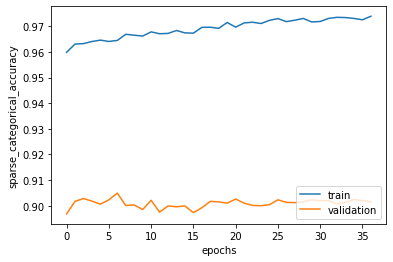

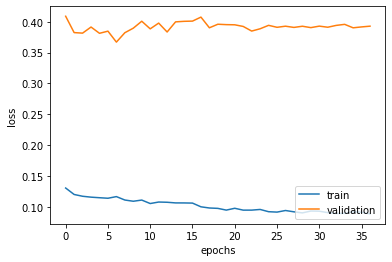

In [0]:
import matplotlib.pyplot as plt

def visual_train_history(history, train_metric, validation_metric):
    plt.plot(history.history[train_metric])
    plt.plot(history.history[validation_metric])
    plt.ylabel(train_metric)
    plt.xlabel('epochs')
    plt.legend(['train','validation'], loc='lower right')
    plt.show()
visual_train_history(history, 'sparse_categorical_accuracy', 'val_sparse_categorical_accuracy')
visual_train_history(history, 'loss', 'val_loss')

In [0]:
history.history


{'loss': [1.20095956325531,
  0.9903414249420166,
  0.9078236222267151,
  0.8494119644165039,
  0.8071415424346924,
  0.7674978971481323,
  0.7365967035293579,
  0.7115366458892822,
  0.680162787437439,
  0.6682966351509094],
 'sparse_categorical_accuracy': [0.604200005531311,
  0.667900025844574,
  0.6937199831008911,
  0.7148600220680237,
  0.7325400114059448,
  0.743619978427887,
  0.7548999786376953,
  0.7653800249099731,
  0.7762600183486938,
  0.7790600061416626],
 'val_loss': [0.8746910095214844,
  0.9618813991546631,
  0.8500453233718872,
  0.6500875353813171,
  0.6365674734115601,
  0.67503422498703,
  0.5965862274169922,
  0.574257493019104,
  0.6203256845474243,
  0.6331219673156738],
 'val_sparse_categorical_accuracy': [0.7141000032424927,
  0.6913999915122986,
  0.7318000197410583,
  0.7832000255584717,
  0.7921000123023987,
  0.782800018787384,
  0.8043000102043152,
  0.8174999952316284,
  0.8052999973297119,
  0.7990000247955322]}

## 模型评价

load model pass
313/313 [==============================] - 10s 32ms/step - loss: 0.3418 - sparse_categorical_accuracy: 0.9226
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9 8 5 7 8 6 7 0 4 9 5 2 4 0 9 6 6 5 4 5 9 2 4
 9 9 5 4 6 5 6 0 9 3 1 7 6]


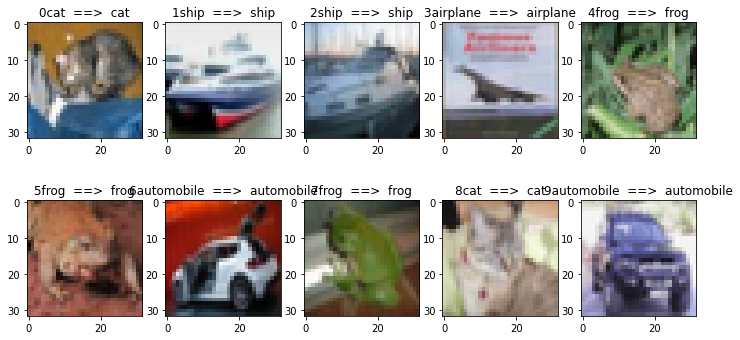

In [0]:
import numpy as np
import matplotlib.pyplot as plt
model_filename = '/content/gdrive/My Drive/cifarResnet18.h5'
try:
    model.load_weights(model_filename)
    print("load model pass")
except:
    print("load model fail")
    
model.evaluate(x_test, y_test)
pred = model.predict(x_test)
pred = np.argmax(pred, axis=1)
print(pred[:50])

label_dict={0:"airplane", 1:"automobile", 2:"bird", 3:"cat",4:"deer",
            5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

def plot_prediction(images, labels, preds, index, nums=5):
    fig = plt.gcf()
    fig.set_size_inches(12,6)
    if nums > 10:
        nums = 10
    for i in range(nums):
        ax = plt.subplot(2,5,i+1)
        ax.imshow(images[index])
        title = str(i) + label_dict[labels[index][0]]
        if (len(preds)>0):
            title += "  ==>  " + label_dict[preds[index]]
        ax.set_title(title, fontsize=12)
        index +=1
    plt.show()
plot_prediction(x_test, y_test, pred, 0 ,10)




In [0]:
!cp results/cifarResnet18.h5 /content/gdrive/My\ Drive


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!ls /content/gdrive


'My Drive'


In [0]:
!ls /content/gdrive/My\ Drive


 cifarResnet18.h5  'Colab Notebooks'   Untitled0.ipynb


In [0]:
!cp results/cifarResnet18.h5 /content/gdrive/My\ Drive


In [0]:
!mkdir results

In [0]:
!cp /content/gdrive/My\ Drive/cifarResnet18.h5 results/

In [0]:
!nvidia-smi

Mon Apr 27 12:53:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    80W / 149W |   4210MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  